In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
import sklearn

from sklearn.ensemble import GradientBoostingRegressor

# load csv

In [2]:
# use 2818.TW as predict target
df2330 = pd.read_csv('04.trade data/trade2330.csv')

# date col
df2330['Date'] = pd.to_datetime(df2330['Date'])
df2330 = df2330.drop(['Date.1'], axis=1)

df2330.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-04-01,264.054176,264.054176,259.279236,259.279236,44515034,0.0,0
1,2020-04-06,260.711742,263.099213,257.846778,263.099213,56392754,0.0,0
2,2020-04-07,270.739121,271.216615,267.874157,270.261627,48787346,0.0,0
3,2020-04-08,272.171631,272.649125,270.261655,272.171631,37912826,0.0,0
4,2020-04-09,274.559074,275.036568,269.784133,270.261627,27620430,0.0,0
5,2020-04-10,267.396653,269.306629,266.441665,266.919159,27252858,0.0,0
6,2020-04-13,265.964142,268.829106,265.964142,265.964142,22196596,0.0,0


# baseline model
- model 1: from close of the day predict close of tomorow
- model 2: from high of the day predict high of tomorrow
- model 3: from low of the day predict low of tomorrow

In [3]:
df2330['y1'] = df2330['Close'].shift(-1)
df2330['y2'] = df2330['High'].shift(-1)
df2330['y3'] = df2330['Low'].shift(-1)

tr, val = df2330[:-int(len(df2330)*0.10)], df2330[-int(len(df2330)*0.10):]
val = val.drop(val.tail(1).index) # Drop last row
tr.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3
0,2020-04-01,264.054176,264.054176,259.279236,259.279236,44515034,0.0,0,263.099213,263.099213,257.846778
1,2020-04-06,260.711742,263.099213,257.846778,263.099213,56392754,0.0,0,270.261627,271.216615,267.874157
2,2020-04-07,270.739121,271.216615,267.874157,270.261627,48787346,0.0,0,272.171631,272.649125,270.261655
3,2020-04-08,272.171631,272.649125,270.261655,272.171631,37912826,0.0,0,270.261627,275.036568,269.784133
4,2020-04-09,274.559074,275.036568,269.784133,270.261627,27620430,0.0,0,266.919159,269.306629,266.441665


In [4]:
def baseline_model_train(train, train_x, train_y, val, val_output):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        "seed": 5271,
        "n_estimators": 300,
        'num_leaves': 10,
        'learning_rate': 0.016,
        'verbose': -1
    }
    
    trn_data = lgb.Dataset(train[train_x].values.reshape(-1,1), label = train[train_y])
    ts_data = lgb.Dataset(val[train_x].values.reshape(-1,1), label = val[train_y])

    model = lgb.train(params,
                     train_set=trn_data)
    
    model_pred = model.predict(val[[train_x,train_y]])
    val[val_output] = model_pred

    return val

In [5]:
val = baseline_model_train(tr, 'Close', 'y1', val,'gbr_pred_y1')
val = baseline_model_train(tr, 'High', 'y2', val,'gbr_pred_y2')
val = baseline_model_train(tr, 'Low', 'y3', val,'gbr_pred_y3')
val.head()

c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3
529,2022-06-02,541.060909,542.055506,537.082520,537.082520,21420890,0.0,0,537.082520,541.060909,535.093325,537.787247,540.588238,536.969039
530,2022-06-06,538.077117,541.060909,535.093325,537.082520,17615003,0.0,0,532.109558,535.093350,529.125766,537.787247,540.588238,536.969039
531,2022-06-07,532.109558,535.093350,529.125766,532.109558,19497532,0.0,0,541.060913,542.055510,535.093329,537.851341,535.635575,531.415209
532,2022-06-08,536.087927,542.055510,535.093329,541.060913,18835521,0.0,0,538.077087,539.071685,534.098699,537.787247,540.588238,536.969039
533,2022-06-09,535.093296,539.071685,534.098699,538.077087,16338602,0.0,0,527.136536,530.120327,526.141938,537.787247,537.424819,531.415209


In [6]:
# mape for model evaluation
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [7]:
print(f'mape of y1: {mape(val["y1"], val["gbr_pred_y1"])}')
print(f'mape of y2: {mape(val["y2"], val["gbr_pred_y2"])}')
print(f'mape of y3: {mape(val["y3"], val["gbr_pred_y3"])}')

mape of y1: 1.78
mape of y2: 1.47
mape of y3: 1.58


In [8]:
model1_results = val.copy()

# model: using a seq of past obs.
- model1: close as y
- model2: high as y
- model3: low as y

In [9]:
# def function to create features of window
def window_func(window_length, input_x, input_y, df):
    data = df.copy()

    i = 1
    while i < window_length:
        data[f'x_{i}'] = df[input_x].shift(-i)
        i += 1
    
    if i == window_length:
        data[input_y] = df[input_x].shift(-i)
    
    data = data.dropna(axis = 0)

    return data

In [10]:
def ma5_model(train, train_x, train_y, val, val_output):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        "seed": 5271,
        "n_estimators": 300,
        'num_leaves': 10,
        'learning_rate': 0.012,
        'verbose': -1
    }
    
    trn_data = lgb.Dataset(train[train_x], label = train[train_y])
    ts_data = lgb.Dataset(val[train_x], label = val[train_y])

    model = lgb.train(params,
                     train_set=trn_data)
    
    model_pred = model.predict(val[train_x+[train_y]])
    val[val_output] = model_pred

    return val

In [11]:
df2330_1 = window_func(5, 'Close', 'y1', df2330)
df2330_1 = window_func(5, 'High', 'y2', df2330_1)
df2330_1 = window_func(5, 'Low', 'y3', df2330_1)

tr, val = df2330_1[:-int(len(df2330_1)*0.10)], df2330_1[-int(len(df2330_1)*0.10):]
tr.head(6)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,x_1,x_2,x_3,x_4
0,2020-04-01,264.054176,264.054176,259.279236,259.279236,44515034,0.0,0,266.919159,269.306629,266.441665,257.846778,267.874157,270.261655,269.784133
1,2020-04-06,260.711742,263.099213,257.846778,263.099213,56392754,0.0,0,265.964142,268.829106,265.964142,267.874157,270.261655,269.784133,266.441665
2,2020-04-07,270.739121,271.216615,267.874157,270.261627,48787346,0.0,0,272.171631,272.649125,267.396690,270.261655,269.784133,266.441665,265.964142
3,2020-04-08,272.171631,272.649125,270.261655,272.171631,37912826,0.0,0,274.559082,275.514070,273.126600,269.784133,266.441665,265.964142,267.396690
4,2020-04-09,274.559074,275.036568,269.784133,270.261627,27620430,0.0,0,273.604095,275.514072,270.261637,266.441665,265.964142,267.396690,273.126600
5,2020-04-10,267.396653,269.306629,266.441665,266.919159,27252858,0.0,0,292.703827,294.613803,286.973899,265.964142,267.396690,273.126600,270.261637


In [12]:
features = ['x_1','x_2','x_3','x_4'] #'Close'
val1 = ma5_model(tr, features, 'y1', val,'gbr_pred_y1')

print(f'mape of y1: {mape(val1["y1"], val1["gbr_pred_y1"])}')

mape of y1: 2.2


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y1"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y1"], mode = "lines", name = "true price"))
fig.show()

In [14]:
model2_results = val1.drop(['x_1','x_2','x_3','x_4'], axis=1)

In [15]:
# df2330_1 = window_func(5, 'High', 'y2', df2618)

tr, val = df2330_1[:-int(len(df2330_1)*0.10)], df2330_1[-int(len(df2330_1)*0.10):]
val1 = ma5_model(tr, features, 'y2', val,'gbr_pred_y2')
print(f'mape of y2: {mape(val["y2"], val["gbr_pred_y2"])}')

mape of y2: 1.77


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y2"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y2"], mode = "lines", name = "true price"))
fig.show()

In [17]:
model2_results = model2_results.merge(val1[['Date', 'gbr_pred_y2']], on='Date', how='left')

In [18]:
# df2618_1 = window_func(5, 'Low', 'y3', df2618)

tr, val = df2330_1[:-int(len(df2330_1)*0.10)], df2330_1[-int(len(df2330_1)*0.10):]
val1 = ma5_model(tr, features, 'y3', val,'gbr_pred_y3')
print(f'mape of y3: {mape(val["y3"], val["gbr_pred_y3"])}')

mape of y3: 1.77


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y3"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y3"], mode = "lines", name = "true price"))
fig.show()

In [20]:
model2_results = model2_results.merge(val1[['Date', 'gbr_pred_y3']], on='Date', how='left')

# model: using a seq of past obs. with feature engineering

## feature engineering

In [21]:
df2330_2 = df2330_1.copy()

def feature_engineering(df):
    # create moving avg
    p = df['Open'].rolling(window = 2).mean()
    df['ma1'] = p.diff()
    df['ma2'] = df['ma1'].diff()
    df['ma3'] = df['ma2'].diff()

    # percent change
    df['high_per'] = (df['High'] - df['Open'])/df['Open']
    df['amplitude'] = (df['High'] - df['Low'])/df['Open']

    # volumn diff percentage for the current day
    df['vol_ma'] = df['Volume'].rolling(window = 5).mean()

    # open diff
    df['open_diff'] = df['Open'].diff()

    # if red K
    df['red_k'] = np.where(df['Close'] > df['Open'], 1, 0)

    # ma5 line we use often
    df['ma5'] = df['Close'].rolling(window = 5).mean()

    return df 

In [22]:
df2330_2 = feature_engineering(df2330_2)
df2330_2['y1'] = df2330_2['Close'].shift(-1)
df2330_2['y2'] = df2330_2['High'].shift(-1)
df2330_2['y3'] = df2330_2['Low'].shift(-1)
df2330_2 = df2330_2.dropna(axis = 0)

tr, val = df2330_2[:-int(len(df2330_2)*0.10)], df2330_2[-int(len(df2330_2)*0.10):]

## training

In [23]:
def lotsoffeature_model(train, train_x, train_y, val, val_output):
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        "seed": 5271,
        "n_estimators": 300,
        'num_leaves': 10,
        'learning_rate': 0.013,
        'verbose': -1
    }
    
    trn_data = lgb.Dataset(train[train_x], label = train[train_y])
    ts_data = lgb.Dataset(val[train_x], label = val[train_y])

    model = lgb.train(params,
                     train_set=trn_data)
    
    model_pred = model.predict(val[train_x+[train_y]])
    val[val_output] = model_pred

    return val

In [24]:
features = ['Open', 'High', 'Low', 'Close', 'ma1', 'ma2', 'ma3', 'high_per', 'amplitude', 'vol_ma', 'open_diff', 'red_k', 'ma5']
val1 = lotsoffeature_model(tr, features, 'y1', val,'gbr_pred_y1')
print(f'mape of y1: {mape(val["y1"], val["gbr_pred_y1"])}')

mape of y1: 1.88


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
# gragh of y1 prediction 
# fig = px.line(val1, x = "Date", y = "gbr_pred_y1", title = "model results")
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y1"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y1"], mode = "lines", name = "true price"))
fig.show()

In [26]:
model3_results = val1.drop(['ma1', 'ma2', 'ma3', 'high_per', 'amplitude', 'vol_ma', 'open_diff', 'red_k', 'ma5'], axis=1).copy()

In [27]:
val1 = lotsoffeature_model(tr, features, 'y2', val,'gbr_pred_y2')
print(f'mape of y2: {mape(val["y2"], val["gbr_pred_y2"])}')

c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



mape of y2: 1.5


c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y2"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y2"], mode = "lines", name = "true price"))
fig.show()

In [29]:
model3_results = model3_results.merge(val1[['Date', 'gbr_pred_y2']], on='Date', how='left')

In [30]:
val1 = lotsoffeature_model(tr, features, 'y3', val,'gbr_pred_y3')
print(f'mape of y3: {mape(val["y3"], val["gbr_pred_y3"])}')

mape of y3: 1.42


c:\Anaconda3\envs\public\lib\site-packages\lightgbm\engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\Anaconda3\envs\public\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# gragh of y1 prediction 
fig = go.Figure()
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["gbr_pred_y3"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val1["Date"], y = val1["y3"], mode = "lines", name = "true price"))
fig.show()

In [32]:
model3_results = model3_results.merge(val1[['Date', 'gbr_pred_y3']], on='Date', how='left')

# model with prophet

## import packages

In [33]:
import prophet
from prophet import Prophet # should be prophet instead of fbprophet
print('Prophet %s' % prophet.__version__) # check package version, should be 0.5 or higher

Prophet 1.1.1


## predict close

In [34]:
df2330_3 = df2330.copy()
df2330_3 = df2330_3[['Date', 'Close']]
df2330_3 = df2330_3.rename({'Date': 'ds', 'Close': 'y'}, axis=1) # input col name must be ds, y
tr, val = df2330_3[:-int(len(df2330_3)*0.10)], df2330_3[-int(len(df2330_3)*0.10):]

In [35]:
model = Prophet(daily_seasonality=True)
model.fit(tr)

13:49:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
pred = val.copy()
future = model.make_future_dataframe(periods=365)
pred = model.predict(future)
# pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

val = val.merge(pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
val.tail()

,ds,y,yhat,yhat_lower,yhat_upper
53,2022-08-17,527.0,508.831360,489.064680,528.475326
54,2022-08-18,520.0,508.364038,489.792089,528.442170
55,2022-08-19,519.0,507.181918,486.538588,526.937736
56,2022-08-22,512.0,505.673089,486.220897,525.239461
57,2022-08-23,504.0,506.530905,485.047715,526.491232


In [37]:
print(f'mape of y1: {mape(val["y"], val["yhat"])}')

mape of y1: 4.23


In [38]:
model4_results = model3_results.drop(['gbr_pred_y1', 'gbr_pred_y2', 'gbr_pred_y3'], axis = 1).copy()
val = val.rename({'ds': 'Date', 'yhat': 'gbr_pred_y1'}, axis=1)
model4_results = model4_results.merge(val[['Date', 'gbr_pred_y1']], on='Date', how='left')

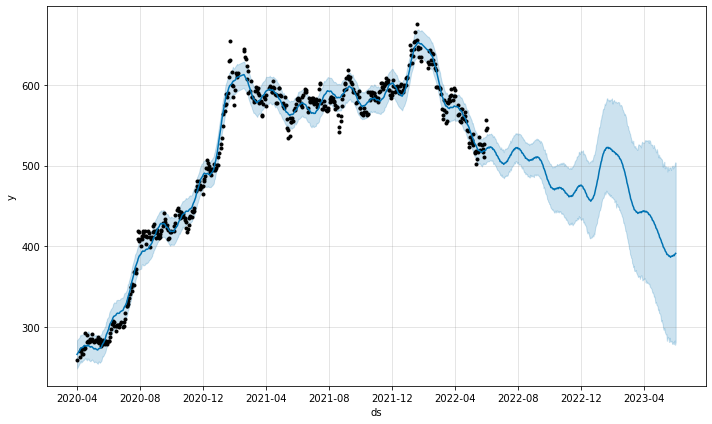

In [39]:
figure1 = model.plot(pred)

In [40]:
# gragh of y1 prediction 
# fig = px.line(val1, x = "Date", y = "gbr_pred_y1", title = "model results")
fig = go.Figure()
fig.add_trace(go.Scatter(x = val["Date"], y = val["gbr_pred_y1"], mode = "lines", name = "prediction"))
fig.add_trace(go.Scatter(x = val["Date"], y = val["y"], mode = "lines", name = "true price"))
fig.show()

## predict high

In [41]:
df2330_3 = df2330.copy()
df2330_3 = df2330[['Date', 'High']]
df2330_3 = df2330_3.rename({'Date': 'ds', 'High': 'y'}, axis=1) # input col name must be ds, y
tr, val = df2330_3[:-int(len(df2330_3)*0.10)], df2330_3[-int(len(df2330_3)*0.10):]

In [42]:
pred = val.copy()
future = model.make_future_dataframe(periods=365)
pred = model.predict(future)

val = val.merge(pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
val.tail()

,ds,y,yhat,yhat_lower,yhat_upper
53,2022-08-17,527.0,508.831360,487.938331,527.837151
54,2022-08-18,521.0,508.364038,488.541464,528.375261
55,2022-08-19,523.0,507.181918,487.405141,526.748626
56,2022-08-22,514.0,505.673089,486.198520,525.222094
57,2022-08-23,506.0,506.530905,485.430011,525.621168


In [43]:
print(f'mape of y2: {mape(val["y"], val["yhat"])}')

mape of y2: 3.55


In [44]:
val = val.rename({'ds': 'Date', 'yhat': 'gbr_pred_y2'}, axis=1)
model4_results = model4_results.merge(val[['Date', 'gbr_pred_y2']], on='Date', how='left')

## predict low

In [45]:
df2330_3 = df2330.copy()
df2330_3 = df2330[['Date', 'Low']]
df2330_3 = df2330_3.rename({'Date': 'ds', 'Low': 'y'}, axis=1) # input col name must be ds, y
tr, val = df2330_3[:-int(len(df2330_3)*0.10)], df2330_3[-int(len(df2330_3)*0.10):]

In [46]:
pred = val.copy()
future = model.make_future_dataframe(periods=365)
pred = model.predict(future)

val = val.merge(pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
val.tail()

,ds,y,yhat,yhat_lower,yhat_upper
53,2022-08-17,521.0,508.831360,488.776372,531.117460
54,2022-08-18,519.0,508.364038,488.578924,529.389238
55,2022-08-19,517.0,507.181918,486.802118,528.531311
56,2022-08-22,510.0,505.673089,485.914660,527.162405
57,2022-08-23,502.0,506.530905,484.671722,526.606554


In [47]:
print(f'mape of y3: {mape(val["y"], val["yhat"])}')

mape of y3: 4.84


In [48]:
val = val.rename({'ds': 'Date', 'yhat': 'gbr_pred_y3'}, axis=1)
model4_results = model4_results.merge(val[['Date', 'gbr_pred_y3']], on='Date', how='left')

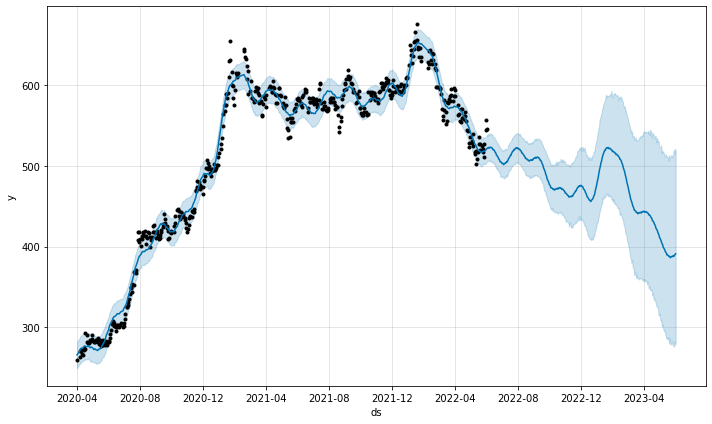

In [49]:
figure3 = model.plot(pred)

# eda of performance of 4 models

In [50]:
del pred, val1, features, df2330_1, df2330_2, df2330_3, future, model

In [51]:
# strategy: buy and sell the next day
# if pred high >= 2% then buy, if y2 >= 2% then sell at 2%, if y3 <= 2%, else sell at close
# if pred low <= 2% then short
def buy_sell_strategy(df):
    df['buy'] = 0
    df['buy_results'] = np.nan
    df['profit_per'] = 0

    for i in range(len(df)):
        if df.loc[i,'gbr_pred_y2'] >= df.loc[i,'Close']*1.02:
            df.loc[i,'buy'] = 1
        else:
            pass
    for i in range(len(df)):
        if df.loc[i,'y2'] >= df.loc[i,'Close']*1.02 and df.loc[i,'y3'] >= df.loc[i,'Close']*0.98:
            df.loc[i,'buy_results'] = df.loc[i,'Close']*1.02
        elif df.loc[i,'y2'] < df.loc[i,'Close']*1.02 and df.loc[i,'y3'] <= df.loc[i,'Close']*0.98:
            df.loc[i,'buy_results'] = df.loc[i,'Close']*0.98
        elif df.loc[i,'y2'] < df.loc[i,'Close']*1.02 and df.loc[i,'y3'] > df.loc[i,'Close']*0.98:
            df.loc[i,'buy_results'] = df.loc[i,'Close']
        else:
            pass 
    for i in range(len(df)):
        if df.loc[i,'buy'] == 1:
            df.loc[i,'profit_per'] = (df.loc[i,'buy_results'] - df.loc[i,'Close'])/df.loc[i,'Close']
        else:
            pass
        
    return df
    

In [52]:
model2_results = buy_sell_strategy(model2_results)
a = model2_results['profit_per'].sum()
print(f'profit of model 2: {a}')

profit of model 2: 0.32000000000000034


In [53]:
# model1_results = buy_sell_strategy(model1_results)
model2_results = buy_sell_strategy(model2_results)
model3_results = buy_sell_strategy(model3_results)
model4_results = buy_sell_strategy(model4_results)

In [54]:
a = model2_results['profit_per'].sum()
print(f'profit of model 2: {a}')
a = model3_results['profit_per'].sum()
print(f'profit of model 3: {a}')
a = model4_results['profit_per'].sum()
print(f'profit of model 4: {a}')
del a 

profit of model 2: 0.32000000000000034
profit of model 3: 3.469446951953614e-17
profit of model 4: 0.020000000000000132


In [55]:
model2_results.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,y3,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3,buy,buy_results,profit_per
0,2022-05-13,504.260808,511.222989,503.266211,508.239197,29074177,0.0,0,527.136536,529.125730,520.174355,523.090850,527.326315,515.902459,1,518.403981,0.02
1,2022-05-16,518.185149,521.168941,515.201357,517.190552,21163106,0.0,0,525.147339,531.114922,525.147339,533.268390,538.102863,528.215517,1,527.534363,0.02
2,2022-05-17,518.185161,530.120327,517.190563,527.136536,24496974,0.0,0,517.190552,528.131121,517.190552,532.913052,537.206369,525.976217,0,527.136536,0.00
3,2022-05-18,538.077115,538.077115,531.114934,535.093323,30568176,0.0,0,521.168945,526.141931,517.190556,522.977127,527.215204,515.902459,0,524.391456,0.00
4,2022-05-19,520.174346,524.152735,517.190554,519.179749,29019751,0.0,0,511.222992,522.163562,510.228395,522.296067,526.727921,518.697710,0,519.179749,0.00
5,2022-05-20,521.168952,529.125730,520.174355,527.136536,22651205,0.0,0,527.136536,527.136536,519.179758,521.870277,526.666393,514.048636,0,527.136536,0.00
6,2022-05-23,530.120325,531.114922,525.147339,525.147339,17054170,0.0,0,544.044678,544.044678,534.098706,530.473015,535.908018,525.059773,1,535.650286,0.02


In [56]:
model3_results.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,...,x_1,x_2,x_3,x_4,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3,buy,buy_results,profit_per
0,2022-05-13,504.260808,511.222989,503.266211,508.239197,29074177,0.0,0,517.190552,521.168941,...,515.201357,517.190563,531.114934,517.190554,507.114879,510.968645,501.204994,0,518.403981,0.0
1,2022-05-16,518.185149,521.168941,515.201357,517.190552,21163106,0.0,0,527.136536,530.120327,...,517.190563,531.114934,517.190554,520.174355,514.161728,519.181995,508.493305,0,527.534363,0.0
2,2022-05-17,518.185161,530.120327,517.190563,527.136536,24496974,0.0,0,535.093323,538.077115,...,531.114934,517.190554,520.174355,525.147339,524.450002,527.100556,516.590789,0,537.679266,0.0
3,2022-05-18,538.077115,538.077115,531.114934,535.093323,30568176,0.0,0,519.179749,524.152735,...,517.190554,520.174355,525.147339,517.190552,535.201952,539.583379,529.999754,0,524.391456,0.0
4,2022-05-19,520.174346,524.152735,517.190554,519.179749,29019751,0.0,0,527.136536,529.125730,...,520.174355,525.147339,517.190552,517.190556,513.597294,518.583225,507.635281,0,519.179749,0.0
5,2022-05-20,521.168952,529.125730,520.174355,527.136536,22651205,0.0,0,525.147339,531.114922,...,525.147339,517.190552,517.190556,510.228395,529.220927,531.185116,523.902779,0,527.136536,0.0
6,2022-05-23,530.120325,531.114922,525.147339,525.147339,17054170,0.0,0,517.190552,528.131121,...,517.190552,517.190556,510.228395,519.179758,533.053266,538.286340,529.539872,1,525.147339,0.0


In [57]:
model4_results.head(7)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,y1,y2,...,x_1,x_2,x_3,x_4,gbr_pred_y1,gbr_pred_y2,gbr_pred_y3,buy,buy_results,profit_per
0,2022-05-13,504.260808,511.222989,503.266211,508.239197,29074177,0.0,0,517.190552,521.168941,...,515.201357,517.190563,531.114934,517.190554,NaN,NaN,NaN,0,518.403981,0.0
1,2022-05-16,518.185149,521.168941,515.201357,517.190552,21163106,0.0,0,527.136536,530.120327,...,517.190563,531.114934,517.190554,520.174355,NaN,NaN,NaN,0,527.534363,0.0
2,2022-05-17,518.185161,530.120327,517.190563,527.136536,24496974,0.0,0,535.093323,538.077115,...,531.114934,517.190554,520.174355,525.147339,NaN,NaN,NaN,0,537.679266,0.0
3,2022-05-18,538.077115,538.077115,531.114934,535.093323,30568176,0.0,0,519.179749,524.152735,...,517.190554,520.174355,525.147339,517.190552,NaN,NaN,NaN,0,524.391456,0.0
4,2022-05-19,520.174346,524.152735,517.190554,519.179749,29019751,0.0,0,527.136536,529.125730,...,520.174355,525.147339,517.190552,517.190556,NaN,NaN,NaN,0,519.179749,0.0
5,2022-05-20,521.168952,529.125730,520.174355,527.136536,22651205,0.0,0,525.147339,531.114922,...,525.147339,517.190552,517.190556,510.228395,NaN,NaN,NaN,0,527.136536,0.0
6,2022-05-23,530.120325,531.114922,525.147339,525.147339,17054170,0.0,0,517.190552,528.131121,...,517.190552,517.190556,510.228395,519.179758,NaN,NaN,NaN,0,525.147339,0.0
